In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil
import numpy as np
from scipy import stats
from tqdm import tqdm
from IPython.display import clear_output

import py21cmfish
from py21cmfish.power_spectra import *
from py21cmfish.io import *

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

from scripts.step_size import decay_phot_lifetime, decay_elec_lifetime, pwave_phot_c_sigma, pwave_elec_c_sigma, pbhhr_f, pbhacc_f

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [2]:
noise_dir = "/n/home07/yitians/dm21cm/21cmSense_fid_EOS21/"
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

## 1. 21cmFISH standard astrophysics

In [3]:
bkg_dir = f"{outputs_dir}/bkg/"

astro_params_vary = ['DM', 'F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR',
                     'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'A_LW']
default_param_values = [0, -1.25, -2.5, 0.5, 0.0, 0.5, -1.35, -1.35, -0.3, 40.5, 40.5, 500, 2.0]

astro_params_vary = list(np.array(astro_params_vary))
default_param_values = default_param_values
astro_params_fid = dict()
for i in range(len(astro_params_vary)):
    astro_params_fid[astro_params_vary[i]] = default_param_values[i]
    
# Load each parameter into a dictionary
params_EoS = {}
for param in astro_params_vary[1:]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir = bkg_dir,
        PS_err_dir = noise_dir,
        new = False
)
clear_output()

## 2. Fisher analysis at each mass

In [7]:
! ls /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr

log10m13.500  log10m15.000  log10m16.500  log10m18.000


In [ ]:
run_name = 'pbhhr'
run_fullname = 'pbhhr'
# model = 'PRc23' # for pbh-acc only
inj_dir = f"{outputs_dir}/active/{run_fullname}"
print(os.listdir(inj_dir))

EPSILON = 1e-6

if run_name == 'decay-phot':
    log10m_s = np.linspace(1.5, 12, 22)
    m_s = 10**log10m_s
    tau_s = decay_phot_lifetime(m_s)
    print('tau', tau_s)
    mass_s = m_s
    inj_s = 1/tau_s

elif run_name == 'decay-elec':
    log10m_s = np.linspace(6.5, 12, 23)
    m_s = 10**log10m_s
    tau_s = decay_elec_lifetime(m_s)
    print('tau', tau_s)
    mass_s = m_s
    inj_s = 1/tau_s

elif run_name == 'pwave-phot':
    # m_s = 10**np.array([1.5] + list(range(2, 11)) + [12])
    m_s = 10**np.array([1.5, 5, 8.5, 12]) # [eV]
    c_s = pwave_phot_c_sigma(m_s)
    print('c', c_s)
    mass_s = m_s
    inj_s = c_s

elif run_name == 'pwave-elec':
    # m_s = 10**np.array([6.5, 8, 9, 10, 11, 12])
    m_s = 10**np.array([6.5, 8.5, 10.5, 12]) # [eV]
    c_s = pwave_elec_c_sigma(m_s)
    print('c', c_s)
    mass_s = m_s
    inj_s = c_s

elif run_name.startswith('pbhhr'):
    log10m_s = np.arange(13.5, 18 + EPSILON, 1.5)
    m_PBH_s = 10 ** log10m_s # [g]
    f_PBH_s = pbh_hr_f(m_PBH_s) # [1]
    print('log10m', log10m_s)
    print('f', f_PBH_s)
    mass_s = m_PBH_s
    inj_s = f_PBH_s

elif run_name.startswith('pbhacc'):
    log10m_s = np.array([0, 2, 4])
    m_PBH_s = 10 ** log10m_s # [M_sun]
    f_PBH_s = pbh_acc_f(m_PBH_s, model) # [1]
    print('log10m', log10m_s)
    print('f', f_PBH_s)
    mass_s = m_PBH_s
    inj_s = f_PBH_s

else: # debug
    log10m_s = np.array([2])
    m_PBH_s = 10 ** log10m_s # [M_sun]
    f_PBH_s = pbh_acc_f(m_PBH_s, model) # [1]
    print('log10m', log10m_s)
    print('f', f_PBH_s)
    mass_s = m_PBH_s
    inj_s = f_PBH_s

['log10m15.000', 'log10m13.500', 'log10m18.000', 'log10m16.500']
log10m [13.5 15.  16.5 18. ]
f [1.00000000e-12 3.16227766e-11 5.62341325e-06 1.00000000e+00]


In [10]:
# Copy the fiducial lightcone in each mass directory
for m in mass_s:
    source_file = f'{bkg_dir}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    target_file = f'{inj_dir}/log10m{np.log10(m):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    if not os.path.isfile(target_file):
        print(f'{np.log10(m):.3f}', end=' ')
        shutil.copyfile(source_file, target_file)

In [11]:
sigma_s = []
force_new = False

for m in tqdm(mass_s):

    lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
    new = ('lc_redshifts.npy' not in os.listdir(lc_dir)) or force_new
    
    for param in astro_params_vary[:1]:
        params_EoS[param] = py21cmfish.Parameter(
            HII_DIM=128, BOX_LEN=256, param=param,
            output_dir=lc_dir,
            PS_err_dir=noise_dir, new=new,
        )

    Fij_matrix_PS, Finv_PS= py21cmfish.make_fisher_matrix(
        params_EoS,
        fisher_params=astro_params_vary,
        hpeak=0.0, obs='PS',
        k_min=0.1, k_max=1,
        sigma_mod_frac=0.2,
        add_sigma_poisson=True
    )
    sigma_s.append(np.sqrt(Finv_PS[0, 0]))
    
sigma_s = np.array(sigma_s)
print('sigma', sigma_s)

  0%|          | 0/4 [00:00<?, ?it/s]

########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/power_spectrum_dict_DM.npy
    Loaded fiducial PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/power_spectrum_fid_21cmsense.npy, shape:(23, 46)
    Loading 21cmsense errors from /n/home07/yitians/dm21cm/21cmSense_fid_EOS21/


 25%|██▌       | 1/4 [00:01<00:03,  1.02s/it]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m13.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m15.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m15.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/ou

 50%|█████     | 2/4 [00:01<00:01,  1.10it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m15.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m15.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m15.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m16.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m16.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/ou

 75%|███████▌  | 3/4 [00:02<00:00,  1.16it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m16.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m16.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m16.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m18.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m18.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/ou

100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m18.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m18.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbh-hr/log10m18.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
sigma [ 67.28579359  20.75699446  19.90076022 138.10925747]


In [12]:
# check sigma as a multiple of step size. recommended: 30-100
sigma_s

array([ 67.28579359,  20.75699446,  19.90076022, 138.10925747])

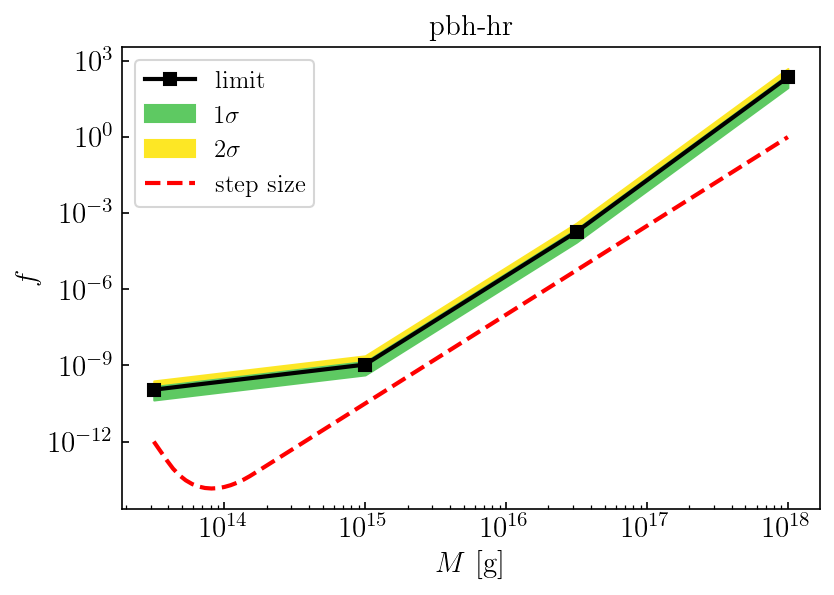

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

ax.plot(mass_s, upper_limit, 'k-s', label='limit')
ax.fill_between(mass_s, upper_limit + one_sigma, upper_limit - one_sigma, color=mpl.colormaps['viridis'](0.75), label='1$\sigma$')
ax.fill_between(mass_s, upper_limit + 2*one_sigma, upper_limit + one_sigma, color=mpl.colormaps['viridis'](1.0), label='2$\sigma$')

ax.set(xscale='log', yscale='log')
ax.set(title=run_fullname)

m_s = np.geomspace(mass_s[0], mass_s[-1], 100)
if run_name == 'decay-phot':
    ax.plot(m_s, 1/decay_phot_lifetime(m_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif run_name == 'decay-elec':
    ax.plot(m_s, 1/decay_elec_lifetime(m_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif run_name == 'pwave-phot':
    ax.plot(m_s, pwave_phot_c_sigma(m_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif run_name == 'pwave-elec':
    ax.plot(m_s, pwave_elec_c_sigma(m_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif run_name.startswith('pbhhr'):
    ax.plot(m_s, pbhhr_f(m_s), 'r--', label='step size')
    ax.set(xlabel=r'$M$ [g]', ylabel=r'$f$')
elif run_name.startswith('pbhacc'):
    ax.plot(m_s, pbhacc_f(m_s, model), 'r--', label='step size')
    ax.set(xlabel=r'$M$ [Msun]', ylabel=r'$f$')
ax.legend()

In [28]:
save_fn = f'../outputs/limits/{run_fullname}.txt'
dir_path = os.path.dirname(save_fn)
os.makedirs(dir_path, exist_ok=True)
np.savetxt(save_fn, np.array([mass_s, inj_s, sigma_s]).T, header='mass_s inj_s sigma_s')